In [1]:
import numpy as np
import pandas as pd

In [2]:
dists = pd.read_pickle('/tf/primo/data/metadata/query_target_dists.pkl.gz')

In [3]:
def nn_recall_discrete(scores, distances, k=100, n_thresholds=500):
    '''given scores (reads) and distance values, compute recall
    and proportion retrieved for a variety of thresholds.
    '''
    # create log space of thresholds
    thresholds = np.unique(np.logspace(0, np.log10(scores.max()), n_thresholds).astype(int))
    
    # retrieved[i, j] says whether item j's score cleared threshold i
    retrieved = scores >= thresholds.reshape(-1,1)
    
    # p_retrieved[i] contains the proportion of items retrieved at threshold i
    p_retrieved = retrieved.mean(1)
    
    # neighbors[i] is the index of the i-th nearest neighbor
    neighbors = distances.argsort()[:k]
    
    # nn_recall[i] is the proportion of k-th nearest neighbors retrieved at threshold i
    nn_recall = retrieved[:, neighbors].mean(1)
    
    return nn_recall, p_retrieved, thresholds

In [4]:
def analyze_counts(run_id):
    run_path = '/tf/primo/data/sequencing/%s/' % run_id
    
    # load run metadata
    run_meta = (
        pd.read_csv(run_path + 'index.csv')
        
        # rename this to match with query-target distance data
        .rename(columns={"query_id":"QueryID"})
    )
    # sequencing index is first column -- set dataframe index to everything else
    run_meta = run_meta.set_index(list(run_meta.columns[1:]))
    
    # load reads
    read_counts = pd.read_pickle(run_path + 'decoded.pkl.gz')
    
    # prepare reads for analysis by joining with distance data and transposing
    data = (
        run_meta
        # join read counts to run metadata
        .join(read_counts, on="sequencing_index")
        .drop(columns="sequencing_index")

        # transpose read counts from columns to rows
        .groupby(run_meta.index.names)
        .apply(
            lambda grp: pd.DataFrame(
                grp.values.flatten(), index=grp.columns.rename("ImageID"), columns=["reads"]
            )
        )

        # join distance data to read counts
        .join(
            dists

            # transpose columns to rows
            .groupby("QueryID")
            .apply(
                lambda grp: pd.DataFrame(
                    grp.values.flatten(), index=grp.columns.rename("ImageID"), columns=["EuclideanDistance"]
                )
            ),

            on=["QueryID","ImageID"]
        )

        # remove unused image IDs
        .dropna()
    )
    
    analysis = (
        data
        # group by all but image ID
        .groupby(data.index.names[:-1])
        # run analysis on each group
        .apply(
            lambda grp: 
                pd.DataFrame(
                    np.column_stack(
                        nn_recall_discrete(
                            grp.reads.values,
                            grp.EuclideanDistance.values,
                            k=100,
                            n_thresholds=500
                        )
                    ),
                    columns=["recall", "prop_retrieved", "threshold"]
                )
        )
    )
    
    return {"run_id": run_id, "run_meta": run_meta, "analysis": analysis}

In [ ]:
run92 = analyze_counts("Run_92")

In [ ]:
run98 = analyze_counts("Run_98")

In [5]:
run_101 = analyze_counts("Run_101")

In [5]:
run_104 = analyze_counts("Run_104")

In [5]:
run_105 = analyze_counts("Run_105")

In [5]:
run_107 = analyze_counts("Run_107")

In [6]:
import matplotlib.pyplot as plt

In [7]:
def plot_baselines(nn_k, n_targets, plt_fn = lambda ax: ax.loglog):
    def plot(ax):
        ax_plot = plt_fn(ax)
        unif = np.linspace(0,1,100)
        ax_plot(unif, unif, alpha=0.2, ls='--', color='black', label='Chance')
        ax_plot(unif, unif * nn_k/n_targets, alpha=0.2, ls='-.', color='black', label='Oracle')
    return plot

Text(0,0.5,'Proportion Retrieved')

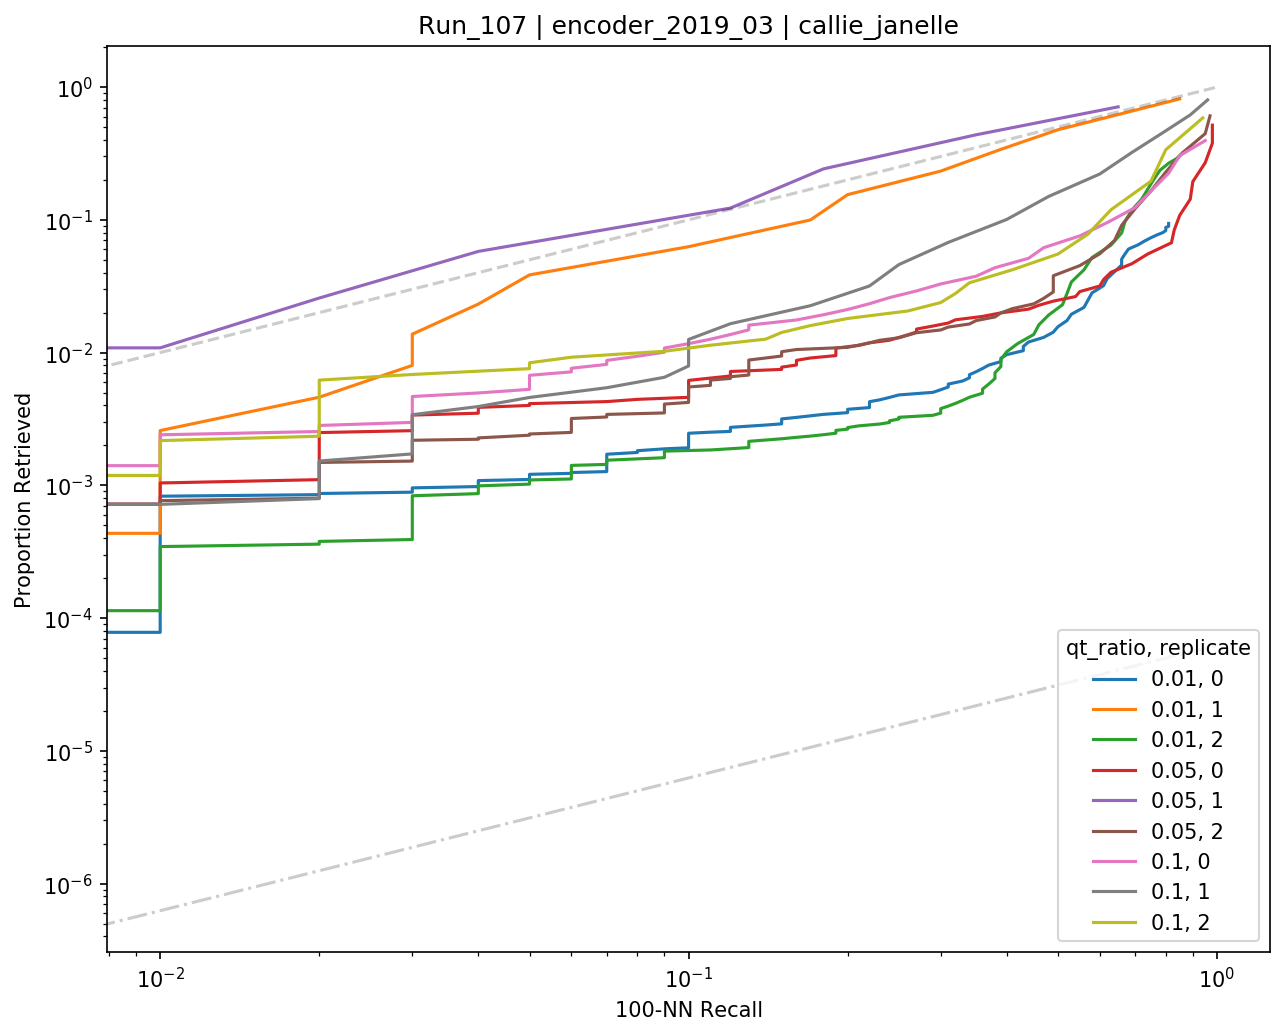

In [9]:
plt.figure(figsize=(10,8), dpi=150)
(   
    run_107['analysis']
    .groupby(["qt_ratio","rep"])
    .apply(
        lambda grp: plt.loglog(grp.recall.values, grp.prop_retrieved.values, label="%g, %d" % grp.name)
    )
)
plt.legend(title='qt_ratio, replicate', loc='lower right')
plot_baselines(100, 1.6e6)(plt.gca())
plt.title("Run_107 | encoder_2019_03 | callie_janelle")
plt.xlabel("100-NN Recall")
plt.ylabel("Proportion Retrieved")

In [10]:
run_105['run_meta'].groupby(["n_randomers","fp_pcr_steps","wash_buffer","rep"]).apply(lambda grp: grp.name)

n_randomers  fp_pcr_steps  wash_buffer  rep
0.0          10            100          0             (0.0, 10, 100, 0)
             100           50           0             (0.0, 100, 50, 0)
                           100          0            (0.0, 100, 100, 0)
8000000.0    10            100          0       (8000000.0, 10, 100, 0)
                                        1       (8000000.0, 10, 100, 1)
16000000.0   10            100          0      (16000000.0, 10, 100, 0)
                                        1      (16000000.0, 10, 100, 1)
dtype: object

Text(0,0.5,'Proportion Retrieved')

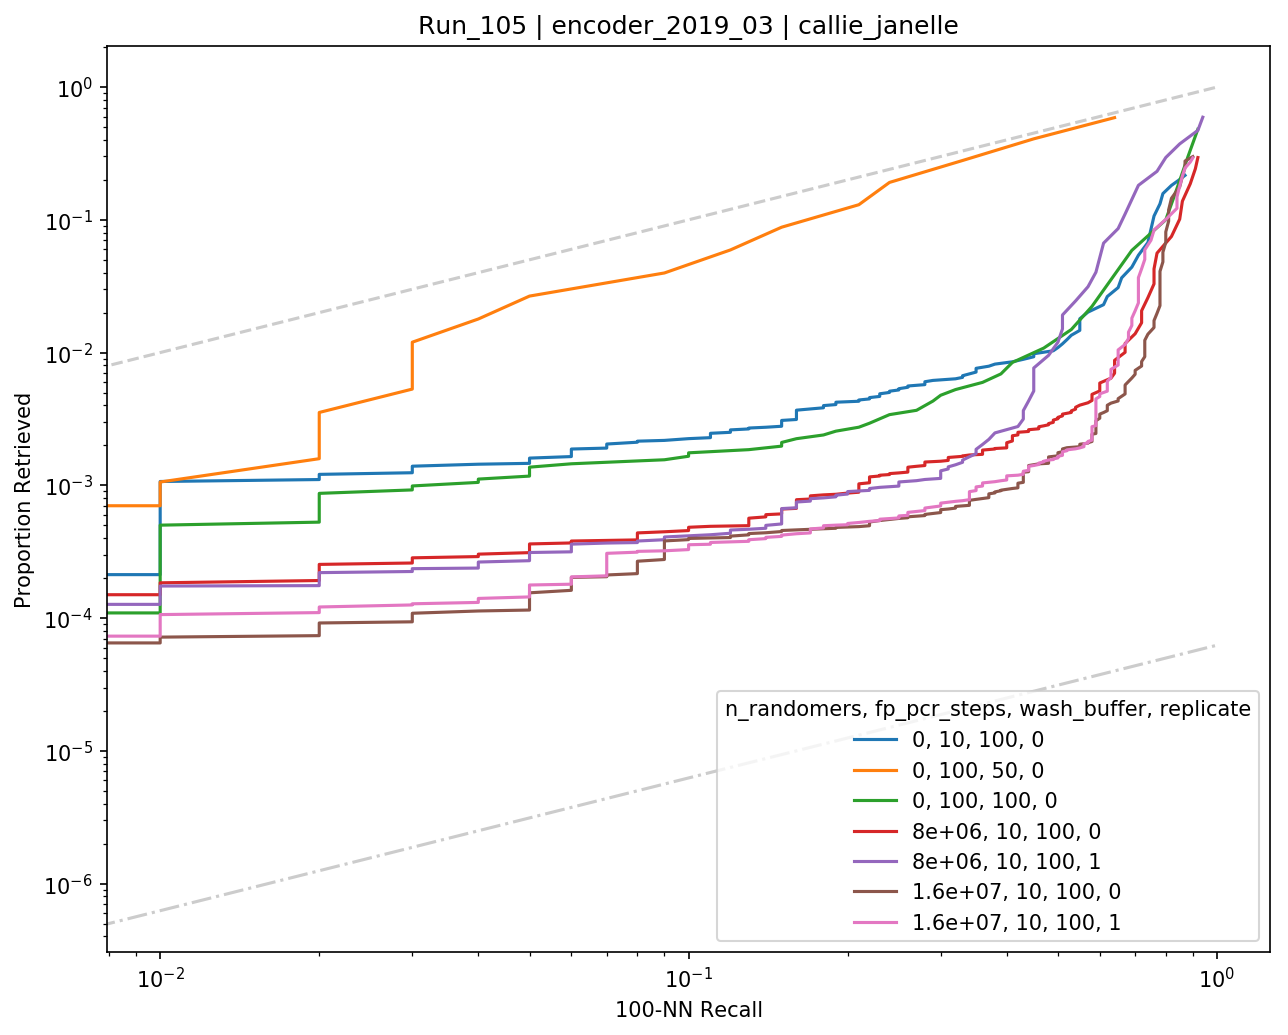

In [12]:
plt.figure(figsize=(10,8), dpi=150)
(   
    run_105['analysis']
    .groupby(["n_randomers","fp_pcr_steps","wash_buffer","rep"])
    .apply(
        lambda grp: plt.loglog(grp.recall.values, grp.prop_retrieved.values, label="%g, %d, %d, %d" % grp.name)
    )
)
plt.legend(title='n_randomers, fp_pcr_steps, wash_buffer, replicate', loc='lower right')
plot_baselines(100, 1.6e6)(plt.gca())
plt.title("Run_105 | encoder_2019_03 | callie_janelle")
plt.xlabel("100-NN Recall")
plt.ylabel("Proportion Retrieved")

In [17]:
run_104['run_meta'].groupby(["n_randomers","poly_t","rep"]).apply(lambda grp: grp.name)

n_randomers   poly_t  rep
0.000000e+00  0       0                (0.0, 0, 0)
                      1                (0.0, 0, 1)
              1       0                (0.0, 1, 0)
                      1                (0.0, 1, 1)
1.600000e+07  0       0         (16000000.0, 0, 0)
1.600000e+08  0       0        (160000000.0, 0, 0)
1.600000e+09  0       0       (1600000000.0, 0, 0)
1.600000e+10  0       0      (16000000000.0, 0, 0)
dtype: object

In [31]:
pd.concat([
    run_104['run_meta'].drop(index=0, level='poly_t'),
    run_104['run_meta'].drop(index=0, level='n_randomers')
])

sequencing_index
encoder         QueryID        qt_ratio dsDNA_conc n_randomers  poly_t rep                 
encoder_2019_03 callie_janelle 0.01     50         0.000000e+00 1      0                 D6
                                                                       1                 E7
                                                   1.600000e+07 0      0                 F8
                                                   1.600000e+08 0      0                H10
                                                   1.600000e+09 0      0                 B9
                                                   1.600000e+10 0      0                 D1

Text(0,0.5,'Proportion Retrieved')

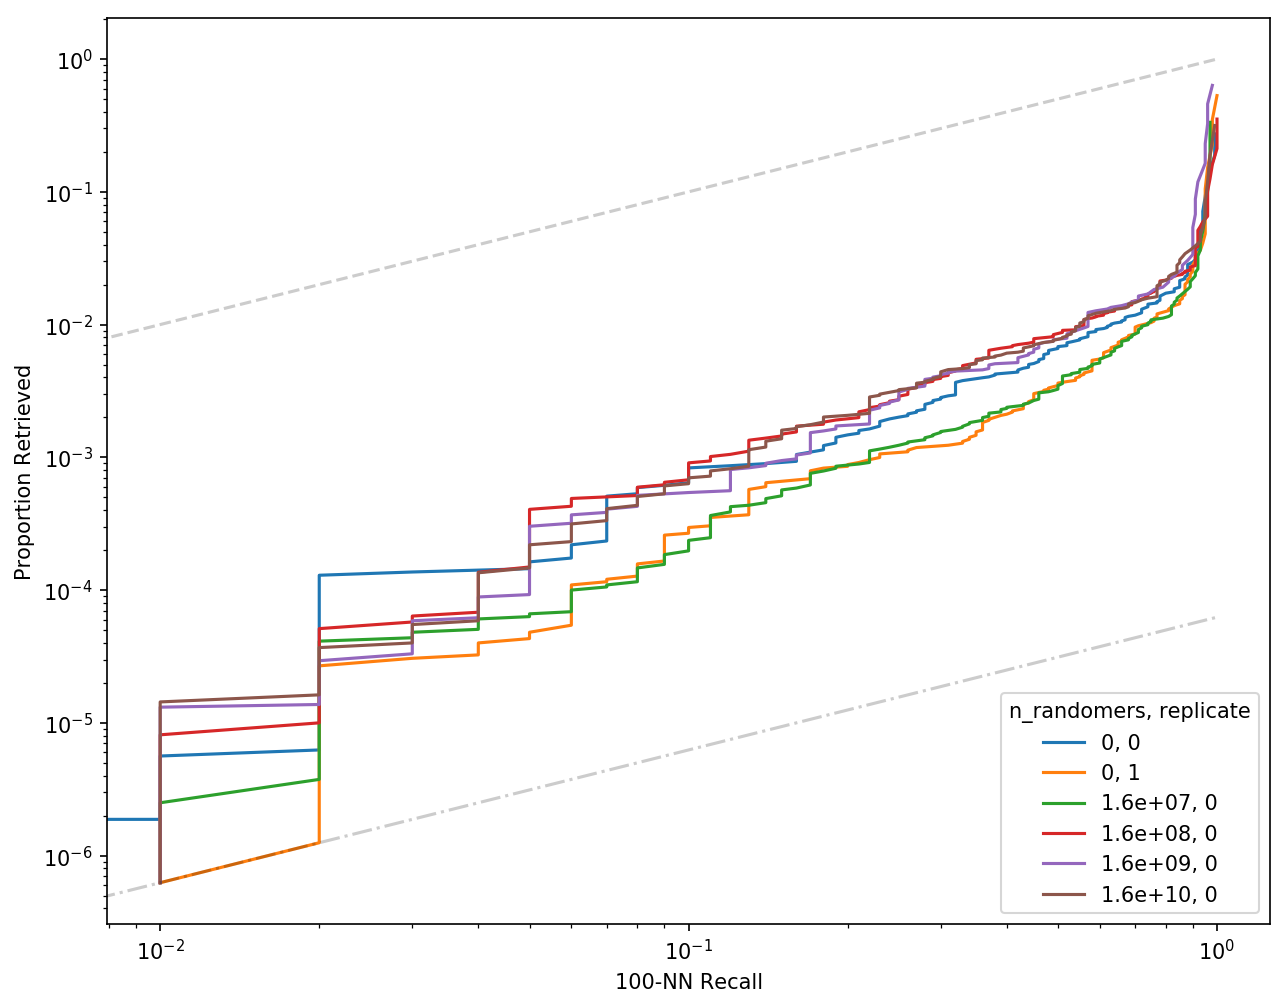

In [34]:
plt.figure(figsize=(10,8), dpi=150)
(
    pd.concat([
        run_104['analysis'].drop(index=0, level='poly_t'),
        run_104['analysis'].drop(index=0, level='n_randomers')
    ])
    .groupby(["n_randomers","rep"])
    .apply(
        lambda grp: plt.loglog(grp.recall.values, grp.prop_retrieved.values, label="%g, %d" % grp.name)
    )
)
plt.legend(title='n_randomers, replicate', loc='lower right')
plot_baselines(100, 1.6e6)(plt.gca())
#plt.title("Run_104 | encoder_2019_03 | callie_janelle")
plt.xlabel("100-NN Recall")
plt.ylabel("Proportion Retrieved")

Text(0,0.5,'Proportion Retrieved')

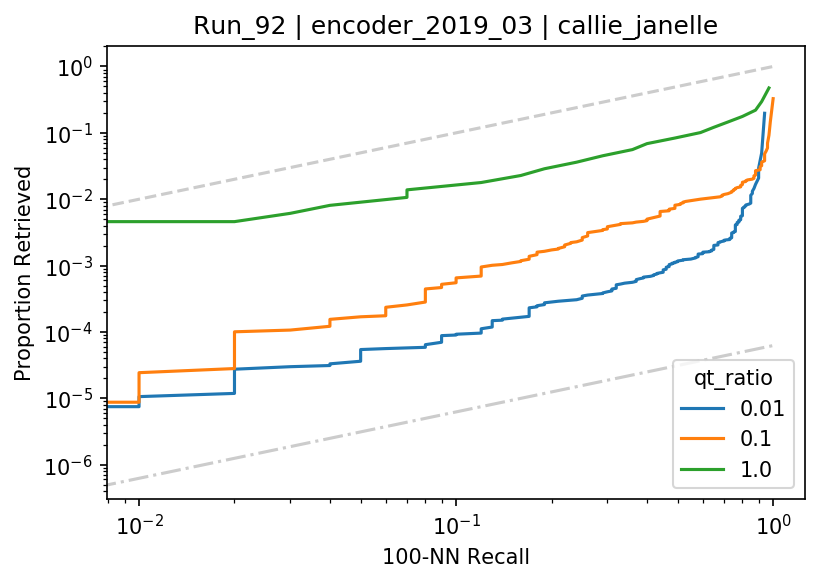

In [23]:
plt.figure(dpi=150)
for qt_ratio in [0.01, 0.10, 1.00]:
    df = run92['analysis'].xs([0, 'encoder_2019_03', qt_ratio], level=['rep', 'encoder', 'qt_ratio'])
    plt.loglog(df.recall.values, df.prop_retrieved.values, label=qt_ratio)
    
plt.legend(title='qt_ratio', loc='lower right')
plot_baselines(100, 1.6e6)(plt.gca())
plt.title("Run_92 | encoder_2019_03 | callie_janelle")
plt.xlabel("100-NN Recall")
plt.ylabel("Proportion Retrieved")

Text(0,0.5,'Proportion Retrieved')

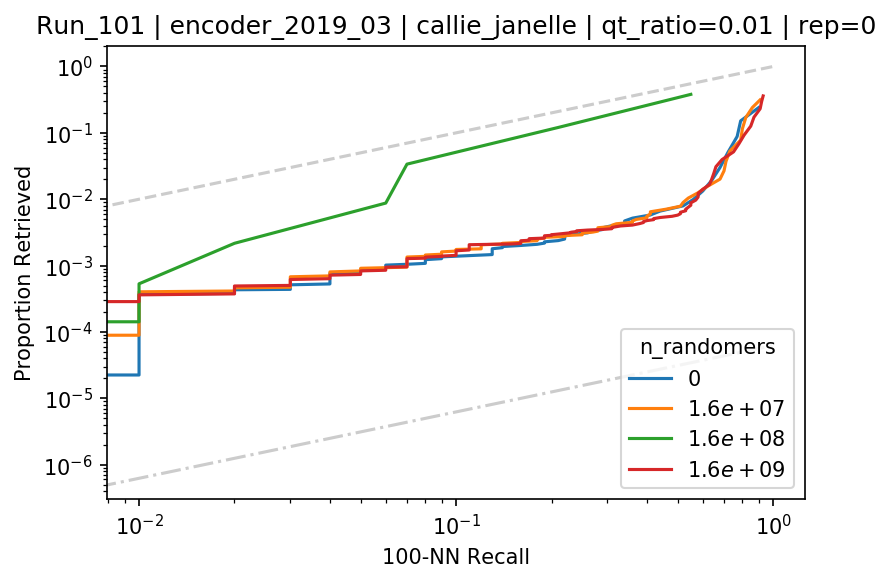

In [12]:
plt.figure(dpi=150)
for n_randomers in [0, 1.6e7, 1.6e8, 1.6e9]:
    df = run_101['analysis'].xs(0, level='rep').xs(n_randomers, level='n_randomers')
    plt.loglog(df.recall.values, df.prop_retrieved.values, label="$%g$"%n_randomers)
    
plt.legend(title='n_randomers', loc='lower right')
plot_baselines(100, 1.6e6)(plt.gca())
plt.title("Run_101 | encoder_2019_03 | callie_janelle | qt_ratio=0.01 | rep=0")
plt.xlabel("100-NN Recall")
plt.ylabel("Proportion Retrieved")

Text(0,0.5,'Proportion Retrieved')

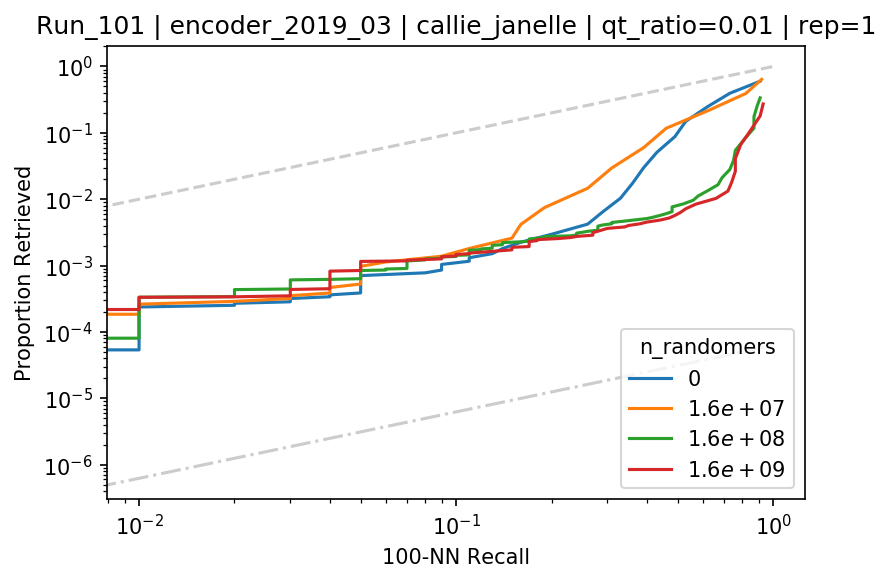

In [13]:
plt.figure(dpi=150)
for n_randomers in [0, 1.6e7, 1.6e8, 1.6e9]:
    df = run_101['analysis'].xs(1, level='rep').xs(n_randomers, level='n_randomers')
    plt.loglog(df.recall.values, df.prop_retrieved.values, label="$%g$"%n_randomers)
    
plt.legend(title='n_randomers', loc='lower right')
plot_baselines(100, 1.6e6)(plt.gca())
plt.title("Run_101 | encoder_2019_03 | callie_janelle | qt_ratio=0.01 | rep=1")
plt.xlabel("100-NN Recall")
plt.ylabel("Proportion Retrieved")